In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_system import linear_system

In [2]:
L = 1E-3
C= 100E-6
R = 100

fs = 10000
gamma = 200
plant_b = np.array([1/(L*C)])
plant_a = np.array([1, 1/(R*C), 1/(L*C)])
reference_b = np.array([1/(L*C)])
reference_a = np.array([1,10/(R*C),1/(L*C)])
filter_b = np.array([10000])
filter_a = np.array([1, 10000])

Gp = linear_system(b=plant_b,
                   a=plant_a, 
                   sampling_rate=fs)

Wm = linear_system(b=reference_b,
                   a=reference_a, 
                   sampling_rate=fs)
# Looks like Wm is unstable under Euler discretization so I had to use a zero order hold as in 
# p.91 of C.T. Chen "Linear System Theory and Design" 3rd Edition, Oxford University Press 1999, New York, Oxford.  
Fy = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)

Fu = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)

Wm_zeta_r = linear_system(b=reference_b,
                          a=reference_a, 
                          sampling_rate=fs)

Wm_zeta_y = linear_system(b=reference_b,
                          a=reference_a, 
                          sampling_rate=fs)

Wm_zeta_w1 = linear_system(b=reference_b,
                          a=reference_a, 
                          sampling_rate=fs)

Wm_zeta_w2 = linear_system(b=reference_b,
                          a=reference_a, 
                          sampling_rate=fs)

rho = (plant_b[-1]/plant_a[-1])/(reference_b[-1]/reference_a[-1])

In [3]:
t_start = 0
t_end = 0.5

t_sim = np.arange(t_start, t_end, 1/fs)

In [4]:
input_signal = 311*np.sin(2*np.pi*60*t_sim)

In [5]:
y = 0
w1 = 0
w2 = 0

N_states = 2+2*(len(filter_a)-1) # r, y, w1, w2  
theta = np.zeros(N_states)

output_signal = np.zeros(len(t_sim))
states_history = np.zeros((N_states,len(t_sim)))

Gp.set_null_state()
Fy.set_null_state()
Fu.set_null_state()
Wm_zeta_r.set_null_state()
Wm_zeta_y.set_null_state()
Wm_zeta_w1.set_null_state()
Wm_zeta_w2.set_null_state()

# reference signal
ym,_  = Wm.simulate_zoh(input_signal, np.zeros(len(reference_a)-1))

for i in range(len(t_sim)):
    # Controler input vector
    omega = np.array([input_signal[i], y, w1, w2])
    
    # zeta is a "filtered" omega vector
    zeta = np.array([Wm_zeta_r.iterate_zoh(input_signal[i]), Wm_zeta_y.iterate_zoh(y), Wm_zeta_w1.iterate_zoh(w1), Wm_zeta_w2.iterate_zoh(w2)])

    # Control action
    states_history[:,i] = theta
    u = omega@theta

    # Unknown plant output
    y = Gp.iterate_zoh(u)
    output_signal[i] = y

    # Filtered states
    w1 = Fu.iterate_zoh(u)
    w2 = Fy.iterate_zoh(y)
    
    #estimation error
    error = y - ym[i]

    # agumented error
    epsilon = error + theta@zeta - w1
    
    # Controler Parameters update
    m2 = 1+zeta@zeta
    theta = theta - gamma * zeta * epsilon * np.sign(rho)/(m2*fs)
    

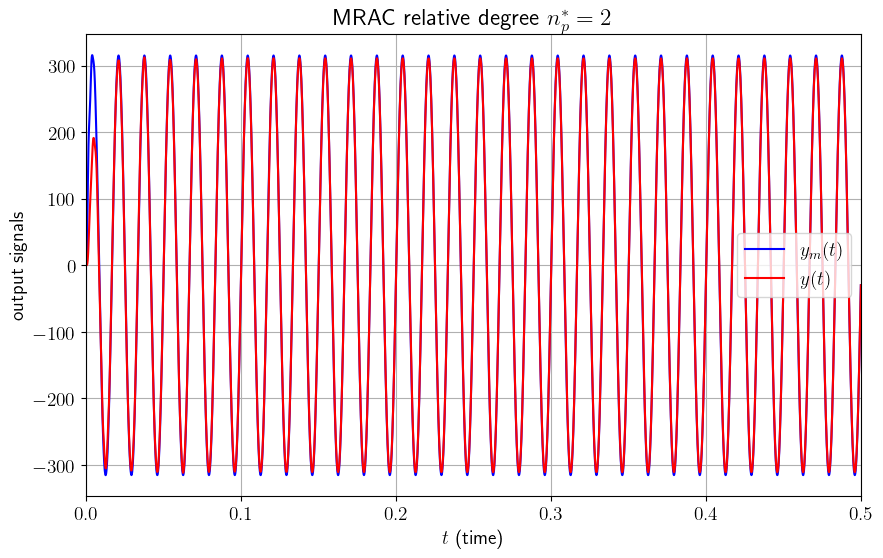

In [6]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.plot(t_sim, ym, 'b', label=r'$y_m(t)$')
plt.plot(t_sim, output_signal, 'r', label=r'$y(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'output signals')
plt.title(r'MRAC relative degree $n_p^*=2$')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
plt.show()

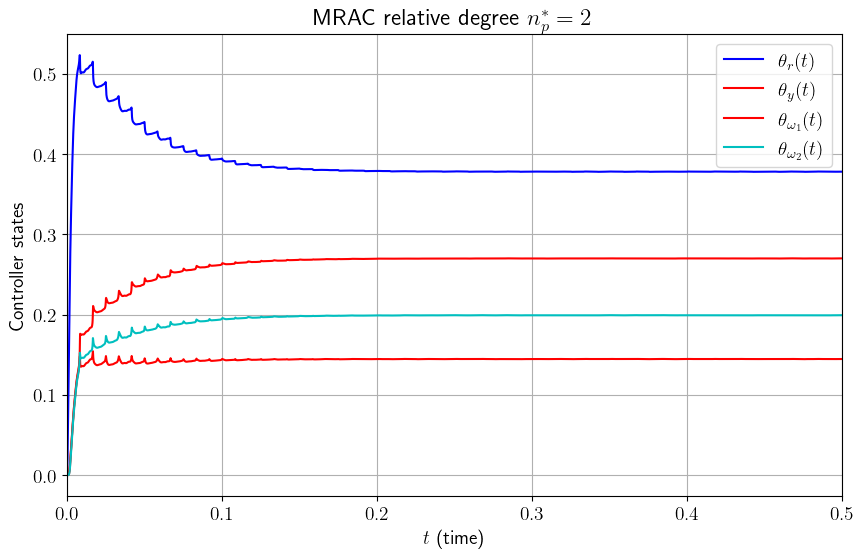

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t_sim, states_history[0,:], 'b', label=r'$\theta_r(t)$')
plt.plot(t_sim, states_history[1,:], 'r', label=r'$\theta_y(t)$')
plt.plot(t_sim, states_history[2,:], 'r', label=r'$\theta_{\omega_1}(t)$')
plt.plot(t_sim, states_history[3,:], 'c', label=r'$\theta_{\omega_2}(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'Controller states')
plt.title(r'MRAC relative degree $n_p^*=2$')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
plt.show()